<a href="https://colab.research.google.com/github/vasconcelosfer/ComputerVisionII/blob/main/TP_VPC2_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TRABAJO PRACTICO FINAL

Alumnos: Fernando Vasconcelos, Victoria Teran y Lara Rosenberg

#### OBJETIVO DEL TRABAJO
Partiendo de imagenes de caras de personas, el objetivo será crear un modelo que identifique si son personas jovenes, de edad media o de edad más avanzada

A lo largo de la notebook vamos a probar las siguientes arquitecturas:
* Un arquitectura definida por nosotros sin Data Augmentation [FER] 15 epocas
* Misma arquitectura con Data Augmentation [FER] 25 epocas
* Transfer Learning con Data Augmentation VGG y Resnet solo reentrenando FC 15 epocas
* Transfer Learning con Data Augmentation VGG y Resnet reentrenando la ultima
capa completa. 15 epocas
* Mejor modelo con diferentes hiperparámetros.


In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 42.3 MB/s eta 0:00:00


In [ ]:
# Importamos las librerias necesarias
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import shutil


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
models_history = {}

In [ ]:
def print_results(history):
  fig, axs = plt.subplots(2, 1, figsize=(10, 10))

  axs[0].plot(history["train_loss"])
  axs[0].plot(history["valid_loss"])
  axs[0].title.set_text('Error de Entrenamiento vs Validación')
  axs[0].legend(['Train', 'Valid'])
  axs[0].grid(True)
  axs[1].plot(history["train_acc"])
  axs[1].plot(history["valid_acc"])
  axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
  axs[1].legend(['Train', 'Valid'])
  axs[1].grid(True)

In [5]:
# Descargamos el dataset
path = kagglehub.dataset_download("arashnic/faces-age-detection-dataset")

dataset_path = path + '/faces/train.csv'
image_folder_path = path + '/faces/Train'

ConnectionError: HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/datasets/view/arashnic/faces-age-detection-dataset (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ff3365660a0>: Failed to resolve 'www.kaggle.com' ([Errno -2] Name or service not known)"))

In [ ]:
# Leemos el csv que tiene el ID de las imagenes y la clase
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


#### Se ha observado que algunas imágenes en el dataset no corresponden a caras de personas o su calidad es muy deficiente para ser utilizar para entrenar el modelo. A continuación mostramos unos ejemplos.

In [ ]:
bad_images = ['25114.jpg', '1801.jpg', '12680.jpg', '18427.jpg', '22376.jpg', '23050.jpg', '14419.jpg', '6223.jpg', '24212.jpg', '15498.jpg','14801.jpg', '23297.jpg', '1750.jpg', '25015.jpg', '8066.jpg']

fig, axes = plt.subplots(3, 5, figsize=(16, 10))

# Iteramos sobre las 15 primeras imágenes
for i, image_file in enumerate(bad_images):
    image_path = os.path.join(image_folder_path, image_file)
    etiqueta = df[df['ID'] == image_file].iloc[0]['Class']

    with Image.open(image_path) as img:
        # Determinar la posición en la matriz
        row = i // 5
        col = i % 5
        # Mostramos la imagen en el gráfico
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{image_file}')

A los efectos de eliminar esta imagenes se llevará a cabo un preprocesamiento del dataset con el objetivo de garantizar que todas las imágenes utilizadas contengan rostros válidos. Para ello, se empleará la herramienta MTCNN (Multi-task Cascaded Convolutional Networks) de la biblioteca facenet-pytorch (https://github.com/timesler/facenet-pytorch?tab=readme-ov-file).

MTCNN es un detector de rostros ampliamente utilizado en aplicaciones de visión por computadora debido a su capacidad para identificar y recortar caras en imágenes de manera precisa y eficiente. Esta herramienta ha sido seleccionada porque ofrece las siguientes ventajas:

Alta precisión en la detección de rostros, incluso en condiciones de iluminación variables o poses no frontales.
Velocidad y escalabilidad, con soporte para procesamiento en GPU, lo cual es esencial para manejar grandes volúmenes de datos.
Facilidad de integración, ya que es compatible con PyTorch y puede aplicarse directamente al dataset sin necesidad de configuraciones adicionales complejas.
El proceso consistirá en aplicar MTCNN sobre cada imagen del dataset. Si no se detecta ningún rostro, la imagen será eliminada del conjunto de datos. Esto permitirá asegurar que las imágenes restantes sean válidas de modo de no afectar el desempeño del modelo entrenado posteriormente.

Este paso es crucial para optimizar la calidad del dataset y garantizar la validez de los resultados obtenidos en las siguientes etapas del proyecto.

Observamos cuantas imagenes tenemos en el dataset

In [ ]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN()
df['face_detected'] = True
for image_file in df['ID']:
    filepath = os.path.join(image_folder_path, image_file)
    try:
        # Detecta las caras
        img = Image.open(filepath)
        boxes, _ = mtcnn.detect(img)
        if boxes is None:  # Si no se detectan caras
            df.loc[df['ID']==image_file, 'face_detected'] = False  # Almacena las imágenes sin caras
    except Exception as e:
        # print(f"Error procesando {image_file}: {e}")
        df.loc[df['ID']==image_file, 'face_detected'] = False

In [ ]:
df.value_counts(df['face_detected'])

Observamos que de las 19906, 4690 no son caras por lo tanto las eliminamos del dataset.

In [ ]:
df = df[df['face_detected'] == True]
df.reset_index(inplace=True)
df = df.drop(columns=['index', 'face_detected'])

In [ ]:
# Guardamos el dataset procesado
# df.to_pickle("./df_cleaned.pkl")

In [3]:
# Cargamos el data frame ya filtrado
df = pd.read_pickle('./df_cleaned.pkl')

In [ ]:
df.shape

(19906, 2)

Evaluamos la distribucion de las clases

In [ ]:
df.Class.value_counts()

,count
Class,
MIDDLE,10804
YOUNG,6706
OLD,2396


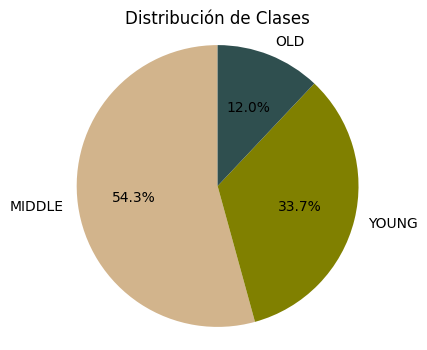

In [ ]:
# Creamos el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(df.Class.value_counts(), labels=df.Class.value_counts().index, autopct='%1.1f%%', startangle=90, colors=['tan', 'olive','darkslategrey'])
plt.axis('equal')

# Agregamos un título
plt.title('Distribución de Clases')

# Mostramos el gráfico
plt.show()

Como podemos ver, las clases se encuentran desbalanceadas.
Más de la mitad de las imagenes, son clasificadas como "middle".
Solo un 12% de las observaciones, corresponden a edades más avanzadas ("old")

Lo primero que vamos a hacer es revisar si todas las imagenes tienen el mismo tamaño

In [4]:
# Obtenemos todos los archivos de la carpeta
image_files = os.listdir(image_folder_path)

# Iniciamos listas para almacenar los valores de ancho y alto
widths = []
heights = []
image_sizes = []

# Iteramos sobre los archivos de la carpeta
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    with Image.open(image_path) as img:
        width, height = img.size
        image_sizes.append(img.size)
        widths.append(width)
        heights.append(height)

# Creamos los gráficos de distribución para ancho y alto
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma del ancho de las imágenes
axes[0].hist(widths, bins=30, color='blue', alpha=0.7)
axes[0].set_title('Distribución de Ancho de las Imágenes')
axes[0].set_xlabel('Ancho (px)')
axes[0].set_ylabel('Frecuencia')

# Histograma del alto de las imágenes
axes[1].hist(heights, bins=30, color='green', alpha=0.7)
axes[1].set_title('Distribución de Alto de las Imágenes')
axes[1].set_xlabel('Alto (px)')
axes[1].set_ylabel('Frecuencia')

# Mostramos los gráficos
plt.tight_layout()
plt.show()

NameError: name 'image_folder_path' is not defined

Como podemos ver, las imagenes presentan distintos tamaños, es decir, no son homogeneas.

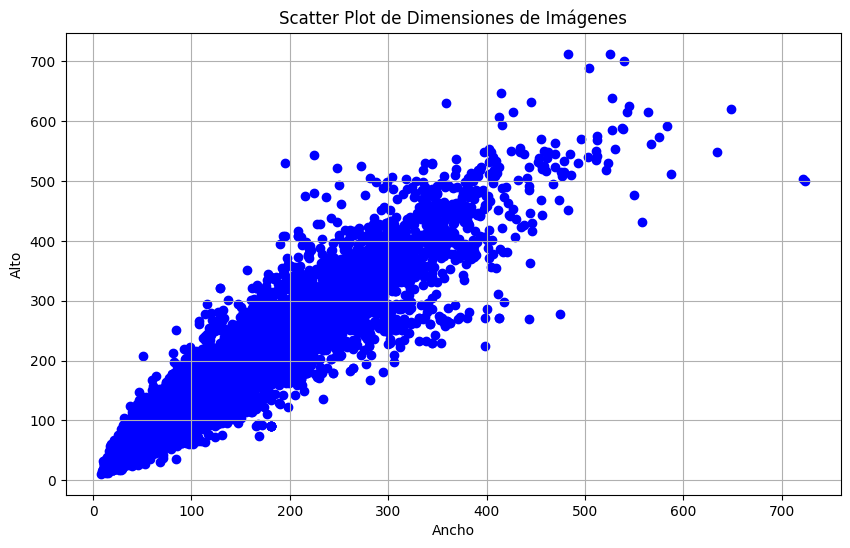

In [ ]:
widths, heights = zip(*image_sizes)

# Creamos el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', marker='o')

# Configuramos el título y las etiquetas
plt.title('Scatter Plot de Dimensiones de Imágenes')
plt.xlabel('Ancho')
plt.ylabel('Alto')
plt.grid(True)

# Mostramos el plot
plt.show()

Como podemos ver, las imágenes no son cuadradas (suelen tener más largo que ancho).

Observamos las primeras 15 imagenes

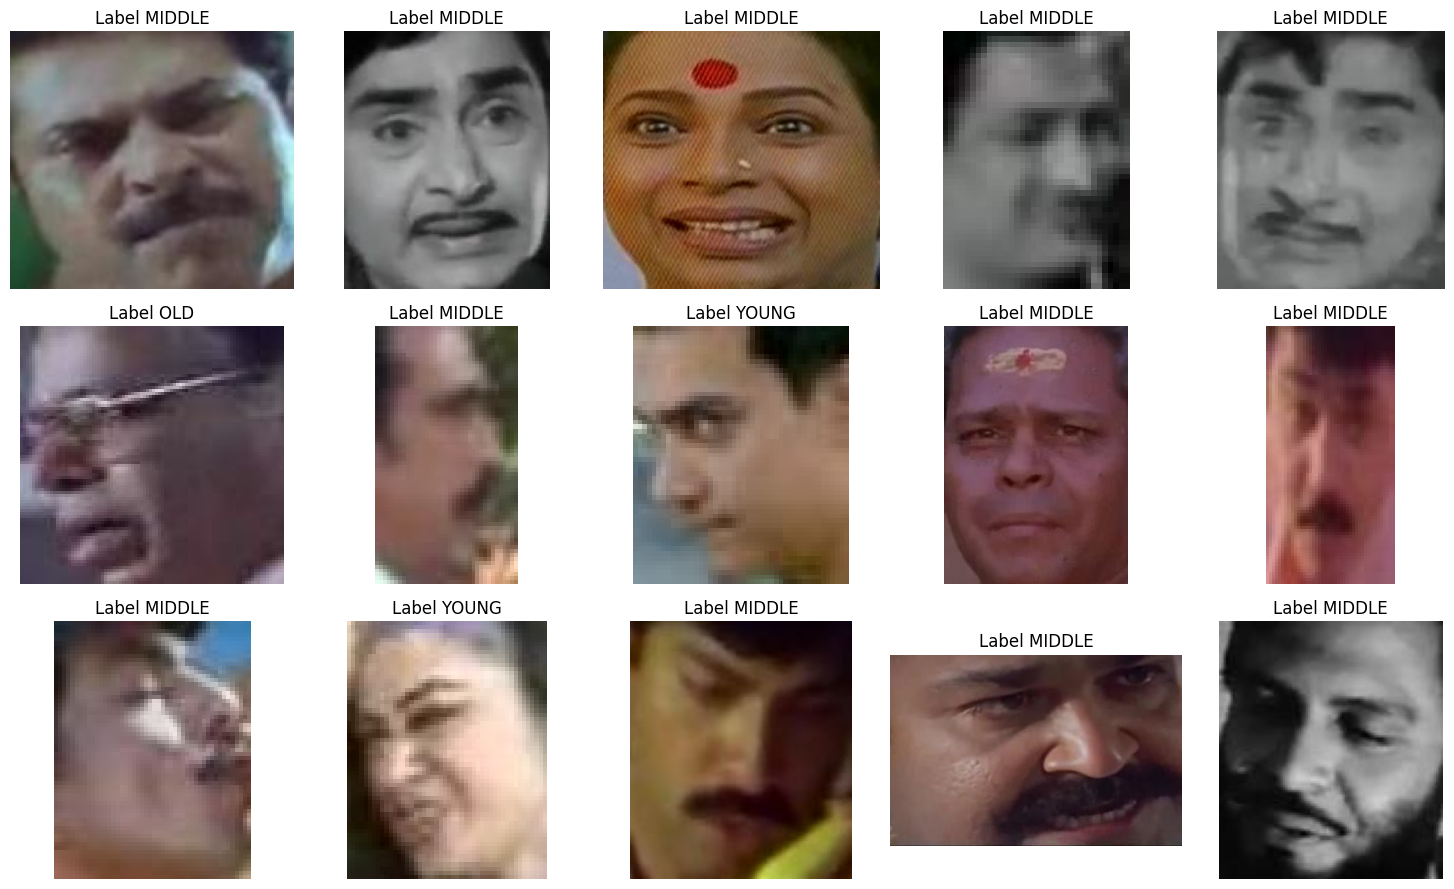

In [ ]:
# Obtenemos todos los archivos de la carpeta
image_files = os.listdir(image_folder_path)
# Obtenemos las primeras 15 imágenes
first_15_images = image_files[:15]

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Iteramos sobre las 15 primeras imágenes
for i, image_file in enumerate(first_15_images):
    image_path = os.path.join(image_folder_path, image_file)
    etiqueta = df[df['ID'] == image_file].iloc[0]['Class']

    with Image.open(image_path) as img:
        # Determinar la posición en la matriz
        row = i // 5
        col = i % 5

        # Mostramos la imagen en el gráfico
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Label {etiqueta}')

# Ajustamos el espacio entre las subgráficas
plt.tight_layout()

# Mostramos el gráfico
plt.show()

In [ ]:
# Data Preprocessing --> cambiamos los labels de str a int
class_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
df['Class'] = df['Class'].map(class_mapping)

In [ ]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

print(f'Tamaño conjunto de entrenamiento: {len(train_df)}')
print(f'Tamaño conjunto de validacion: {len(valid_df)}')

Tamaño conjunto de entrenamiento: 15924
Tamaño conjunto de validacion: 3982


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Nombre de la imagen (ID)
        label = self.dataframe.iloc[idx, 1]     # Clase correspondiente
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Tamaño original de la imagen: 309x387


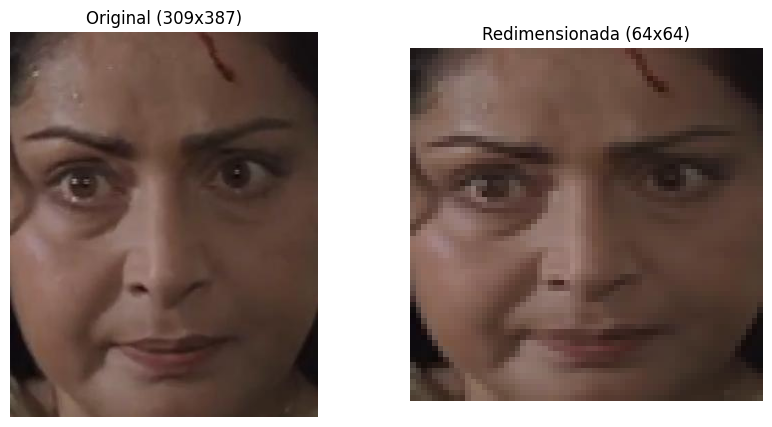

In [ ]:
# Cargamos la imagen original
img_path = image_folder_path + '/1.jpg'
original_image = Image.open(img_path)

# Mostramos las dimensiones de la imagen original
original_size = original_image.size
print(f"Tamaño original de la imagen: {original_size[0]}x{original_size[1]}")

# Definimos el tamaño del resize
resize_transform = transforms.Resize((112, 112), interpolation=Image.LANCZOS)

# Aplicamos la transformación sobre la imagen
resized_image = resize_transform(original_image)

# Mostramos las imágenes: original y redimensionada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image)
axes[0].set_title(f"Original ({original_size[0]}x{original_size[1]})")
axes[0].axis("off")

resized_size = resized_image.size
axes[1].imshow(resized_image)
axes[1].set_title(f"Redimensionada ({resized_size[0]}x{resized_size[1]})")
axes[1].axis("off")

plt.show()

In [ ]:
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 112
ALTO_IMAGENES = 112

In [ ]:
transform = transforms.Compose([
    transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
    transforms.ToTensor(),
])

In [ ]:
# Creamos los datasets
train_dataset = CustomDataset(dataframe=train_df, images_dir=image_folder_path, transform=transform)
test_dataset = CustomDataset(dataframe=valid_df, images_dir=image_folder_path, transform=transform)

# Creamos los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

1. ARQUITECTURA BASICA

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units, dropout_ratio=0.4, dropout2d_ratio=0.3):
        super().__init__()
        self.dropout2d = torch.nn.Dropout2d(dropout2d_ratio)
        self.dropout = torch.nn.Dropout(p=dropout_ratio)

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = torch.nn.BatchNorm2d(128)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.bn5  = torch.nn.BatchNorm2d(256)
        self.pool5 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=2304, out_features=256)
        self.fc2 = torch.nn.Linear(in_features=256, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout2d(x)
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = self.dropout2d(x)
        x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

In [ ]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    if tb_writer:
      train_writer = tb_writer["train"]
      valid_writer = tb_writer["valid"]
      train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
      valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    # if torch.cuda.is_available():
    #     model.to("cuda")
    #     metric.to("cuda")


    model.to(device)
    metric.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # if torch.cuda.is_available():
            #     train_data = train_data.to("cuda")
            #     train_target = train_target.to("cuda")

            train_data = train_data.to(device)
            train_target = train_target.to(device)

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [ ]:
# Dado que las clases se encuentran desbalanceadas vamos a utilizar el argumento weight de CrossEntropy
class_counts = np.bincount(train_dataset.dataframe.Class)
class_weights = 1. / class_counts  # Invertir la frecuencia para dar más peso a las clases menos frecuentes
class_weights = class_weights / class_weights.sum()
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES, dropout_ratio=0.4, dropout2d_ratio=0.3)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001, weight_decay=0.001)
noaug_loss = torch.nn.CrossEntropyLoss(weight=weights)
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
noaug_data = {"train": train_loader, "valid": test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                20,
                None)

In [ ]:
print_results(history)

2. DATA AUGMENTATION

Como estamos trabajando con imágenes de caras de personas, es importante asegurarnos de que las transformaciones no distorsionen los rasgos faciales. Por ejemplo, hacer una rotación demasiado grande o un escalado excesivo podría alterar la posición de los ojos, la nariz o la boca, lo cual podría hacer que el modelo no aprenda correctamente.

Transformaciones propuestas:

transforms.RandomHorizontalFlip:
Refleja las caras horizontalmente sin perder ningún detalle relevante. Esto puede ayudar al modelo a aprender a reconocer las caras sin importar la dirección en la que están orientadas. Uso: transforms.RandomHorizontalFlip(p=0.5) (50% de probabilidad de hacer el flip).

transforms.RandomRotation:
Las rotaciones moderadas pensamos que pueden ser útiles en este caso. Uso: transforms.RandomRotation(degrees=15) (esto permite rotaciones aleatorias de hasta 15 grados en ambas direcciones).

transforms.ColorJitter:
Esta transformación ajusta aleatoriamente el brillo, contraste, saturación y tonalidad de la imagen. Ayuda a hacer que el modelo sea robusto frente a variaciones de iluminación y color en las caras. Uso: transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1).

transforms.RandomAffine:
Permite aplicar transformaciones de traslación, rotación, escalado y/o sesgo en las imágenes. Uso: transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)). Esto permite pequeñas rotaciones (10°), desplazamientos (10% de la imagen) y escalados moderados.

transforms.RandomPerspective:
Realiza transformaciones de perspectiva que pueden hacer que la imagen se vea como si fuera tomada desde otro ángulo. Es útil para robustecer al modelo frente a cambios de perspectiva de la imagen. Uso: transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3).

In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])

In [ ]:
transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])

# Creamos los Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=image_folder_path, transform=aug_data_transforms)
aug_test_set = CustomDataset(dataframe=valid_df, images_dir=image_folder_path, transform=transforms)

# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)


In [ ]:
transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])

# Creamos los Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=image_folder_path, transform=aug_data_transforms)
aug_test_set = CustomDataset(dataframe=valid_df, images_dir=image_folder_path, transform=transforms)

# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)


In [ ]:
aug_conv_model = ConvModel(CANTIDAD_CLASES, dropout_ratio=0.3, dropout2d_ratio=0.2)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(),lr=0.001, weight_decay=0.0001)
aug_loss = torch.nn.CrossEntropyLoss(weight=weights)
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
aug_data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                40,
                None)

# FER: DOS PRIMERAS ARQUITECTURAS.

--------------
# VIC
--------------




### DATA AUGMENTATION Y PESOS

In [ ]:
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])

transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])


images_dir = '/content/faces-age-detection-dataset/faces/Train'

# Creamos los Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=images_dir, transform=aug_data_transforms)
aug_valid_set = CustomDataset(dataframe=valid_df, images_dir=images_dir, transform=transforms)

# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_valid_loader = DataLoader(aug_valid_set, batch_size=64, shuffle=False)

In [ ]:
train_df.Class.value_counts(dropna=False).sort_index()

,count
Class,
0,5364
1,8643
2,1917


In [ ]:
valid_df.Class.value_counts(dropna=False).sort_index()

,count
Class,
0,1342
1,2161
2,479


In [ ]:
frecuencias = train_df.Class.value_counts(dropna=False).sort_index().to_list()
frecuencias

[5364, 8643, 1917]

In [ ]:
weights = [1.0 / f for f in frecuencias]

print(weights)

normalized_weights = [w / sum(weights) for w in weights]
print(normalized_weights)

[0.00018642803877703205, 0.00011570056693277797, 0.0005216484089723526]
[0.22630886205165784, 0.14045131737187233, 0.6332398205764698]


In [ ]:
class_weights_tensor = torch.FloatTensor(normalized_weights)
class_weights_tensor = class_weights_tensor.to('cuda')

# 3. TRANSFER LEARNING VGG19 FC

In [ ]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
vgg19_model = torchvision.models.vgg19(weights=weights)

vgg19_model.to("cuda")

print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#Congelamos todas las capas excepto la fully connected
for param in vgg19_model.parameters():
    param.requires_grad = False

#Cambiamos el output de la fully connected ajustandolo a nuestro problema de clasificacion
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)


check_requires_grad(vgg19_model)

features.0.weight: requires_grad = False
features.0.bias: requires_grad = False
features.2.weight: requires_grad = False
features.2.bias: requires_grad = False
features.5.weight: requires_grad = False
features.5.bias: requires_grad = False
features.7.weight: requires_grad = False
features.7.bias: requires_grad = False
features.10.weight: requires_grad = False
features.10.bias: requires_grad = False
features.12.weight: requires_grad = False
features.12.bias: requires_grad = False
features.14.weight: requires_grad = False
features.14.bias: requires_grad = False
features.16.weight: requires_grad = False
features.16.bias: requires_grad = False
features.19.weight: requires_grad = False
features.19.bias: requires_grad = False
features.21.weight: requires_grad = False
features.21.bias: requires_grad = False
features.23.weight: requires_grad = False
features.23.bias: requires_grad = False
features.25.weight: requires_grad = False
features.25.bias: requires_grad = False
features.28.weight: requ

Epoch: 1/2 - Train loss 1.029409 - Train Accuracy 0.465049 - Valid Loss 1.003870 - Valid Accuracy 0.482356
Epoch: 2/2 - Train loss 0.976268 - Train Accuracy 0.515017 - Valid Loss 0.991738 - Valid Accuracy 0.498734
CPU times: user 4min 27s, sys: 3.34 s, total: 4min 30s
Wall time: 4min 36s


'\nEpoch: 1/15 - Train loss 0.908812 - Train Accuracy 0.411135 - Valid Loss 0.878443 - Valid Accuracy 0.447965\nEpoch: 2/15 - Train loss 0.863930 - Train Accuracy 0.436414 - Valid Loss 0.871109 - Valid Accuracy 0.450418\nEpoch: 3/15 - Train loss 0.851005 - Train Accuracy 0.445978 - Valid Loss 0.852914 - Valid Accuracy 0.457616\nEpoch: 4/15 - Train loss 0.845271 - Train Accuracy 0.455378 - Valid Loss 0.854259 - Valid Accuracy 0.459024\nEpoch: 5/15 - Train loss 0.837145 - Train Accuracy 0.458420 - Valid Loss 0.850263 - Valid Accuracy 0.462013\nEpoch: 6/15 - Train loss 0.832855 - Train Accuracy 0.460505 - Valid Loss 0.838196 - Valid Accuracy 0.462470\nEpoch: 7/15 - Train loss 0.827826 - Train Accuracy 0.465506 - Valid Loss 0.835158 - Valid Accuracy 0.462690\nEpoch: 8/15 - Train loss 0.824457 - Train Accuracy 0.470708 - Valid Loss 0.837216 - Valid Accuracy 0.468337\nEpoch: 9/15 - Train loss 0.823576 - Train Accuracy 0.472499 - Valid Loss 0.837935 - Valid Accuracy 0.466793\nEpoch: 10/15 - T

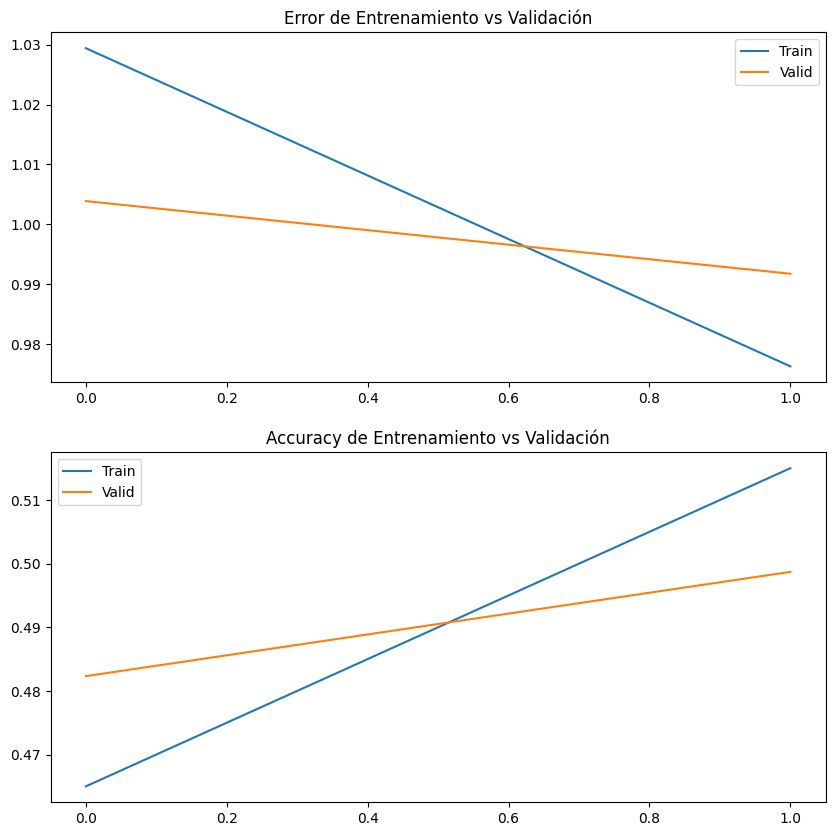

In [ ]:
%%time

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vgg19_model.parameters()),lr=0.0001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
#writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
#          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}


history = train(vgg19_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                2)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])


"""
Epoch: 1/15 - Train loss 0.908812 - Train Accuracy 0.411135 - Valid Loss 0.878443 - Valid Accuracy 0.447965
Epoch: 2/15 - Train loss 0.863930 - Train Accuracy 0.436414 - Valid Loss 0.871109 - Valid Accuracy 0.450418
Epoch: 3/15 - Train loss 0.851005 - Train Accuracy 0.445978 - Valid Loss 0.852914 - Valid Accuracy 0.457616
Epoch: 4/15 - Train loss 0.845271 - Train Accuracy 0.455378 - Valid Loss 0.854259 - Valid Accuracy 0.459024
Epoch: 5/15 - Train loss 0.837145 - Train Accuracy 0.458420 - Valid Loss 0.850263 - Valid Accuracy 0.462013
Epoch: 6/15 - Train loss 0.832855 - Train Accuracy 0.460505 - Valid Loss 0.838196 - Valid Accuracy 0.462470
Epoch: 7/15 - Train loss 0.827826 - Train Accuracy 0.465506 - Valid Loss 0.835158 - Valid Accuracy 0.462690
Epoch: 8/15 - Train loss 0.824457 - Train Accuracy 0.470708 - Valid Loss 0.837216 - Valid Accuracy 0.468337
Epoch: 9/15 - Train loss 0.823576 - Train Accuracy 0.472499 - Valid Loss 0.837935 - Valid Accuracy 0.466793
Epoch: 10/15 - Train loss 0.822385 - Train Accuracy 0.475256 - Valid Loss 0.835726 - Valid Accuracy 0.467360
Epoch: 11/15 - Train loss 0.819955 - Train Accuracy 0.476504 - Valid Loss 0.852942 - Valid Accuracy 0.465463
Epoch: 12/15 - Train loss 0.816826 - Train Accuracy 0.479052 - Valid Loss 0.830175 - Valid Accuracy 0.468876
Epoch: 13/15 - Train loss 0.817501 - Train Accuracy 0.471448 - Valid Loss 0.832303 - Valid Accuracy 0.474197
Epoch: 14/15 - Train loss 0.817960 - Train Accuracy 0.486540 - Valid Loss 0.823682 - Valid Accuracy 0.470049
Epoch: 15/15 - Train loss 0.817499 - Train Accuracy 0.479971 - Valid Loss 0.834366 - Valid Accuracy 0.478292
"""

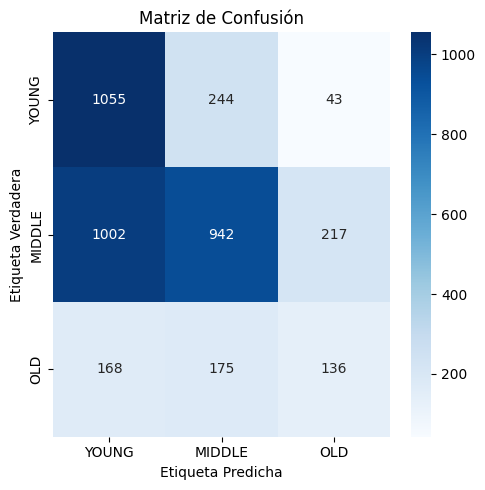

In [ ]:
#Realizamos las predicciones con el modelo
y_true, y_pred = calcular_matriz_confusion(vgg19_model, aug_valid_loader)

#Calculamos la matriz de confusion
matriz_confusion = confusion_matrix(y_true, y_pred)

clases = ['YOUNG', 'MIDDLE', 'OLD']

#Ploteamos la matriz de confusion
graficar_matriz_confusion(matriz_confusion, clases)

In [ ]:
model_name = "vgg19_fc"
models_history[model_name] = history

# 4. TRANSFER LEARNING RESNET18 FC

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
resnet18_model = resnet18(weights=weights)

resnet18_model.to("cuda")

print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Congelamos todas las capas excepto la fully connected
for param in resnet18_model.parameters():
    param.requires_grad = False

#Cambiamos el output de la fully connected ajustandolo a nuestro problema de clasificacion
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)


check_requires_grad(resnet18_model)

conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer2.0.conv1.weight: requires_grad = False
layer2.0.bn1.weight: requires_grad = False
layer2.0.bn1.bias: requires_grad = False
layer2.0.conv2.weight: requires_grad = False
layer2.0.bn2.weight: requires_grad = False
layer2.0.bn2.bias: requires_grad = False
layer2.0.downsample.0.weight: requires_grad = False
layer2.0.downsample.1.weight: requires_grad = False
layer2.0.downsample.

Epoch: 1/2 - Train loss 1.116357 - Train Accuracy 0.382894 - Valid Loss 1.063134 - Valid Accuracy 0.437450
Epoch: 2/2 - Train loss 1.020269 - Train Accuracy 0.477329 - Valid Loss 1.040999 - Valid Accuracy 0.470160
CPU times: user 3min 2s, sys: 6.77 s, total: 3min 9s
Wall time: 3min 10s


'\nEpoch: 1/15 - Train loss 0.985177 - Train Accuracy 0.374684 - Valid Loss 0.968115 - Valid Accuracy 0.385228\nEpoch: 2/15 - Train loss 0.895310 - Train Accuracy 0.419243 - Valid Loss 0.934302 - Valid Accuracy 0.418434\nEpoch: 3/15 - Train loss 0.866865 - Train Accuracy 0.437861 - Valid Loss 0.923185 - Valid Accuracy 0.431637\nEpoch: 4/15 - Train loss 0.847533 - Train Accuracy 0.449203 - Valid Loss 0.918754 - Valid Accuracy 0.446518\nEpoch: 5/15 - Train loss 0.835963 - Train Accuracy 0.457448 - Valid Loss 0.897940 - Valid Accuracy 0.445474\nEpoch: 6/15 - Train loss 0.820139 - Train Accuracy 0.467866 - Valid Loss 0.892738 - Valid Accuracy 0.451844\nEpoch: 7/15 - Train loss 0.813855 - Train Accuracy 0.469385 - Valid Loss 0.900516 - Valid Accuracy 0.451099\nEpoch: 8/15 - Train loss 0.805010 - Train Accuracy 0.481770 - Valid Loss 0.887045 - Valid Accuracy 0.451594\nEpoch: 9/15 - Train loss 0.802300 - Train Accuracy 0.482244 - Valid Loss 0.878832 - Valid Accuracy 0.461448\nEpoch: 10/15 - T

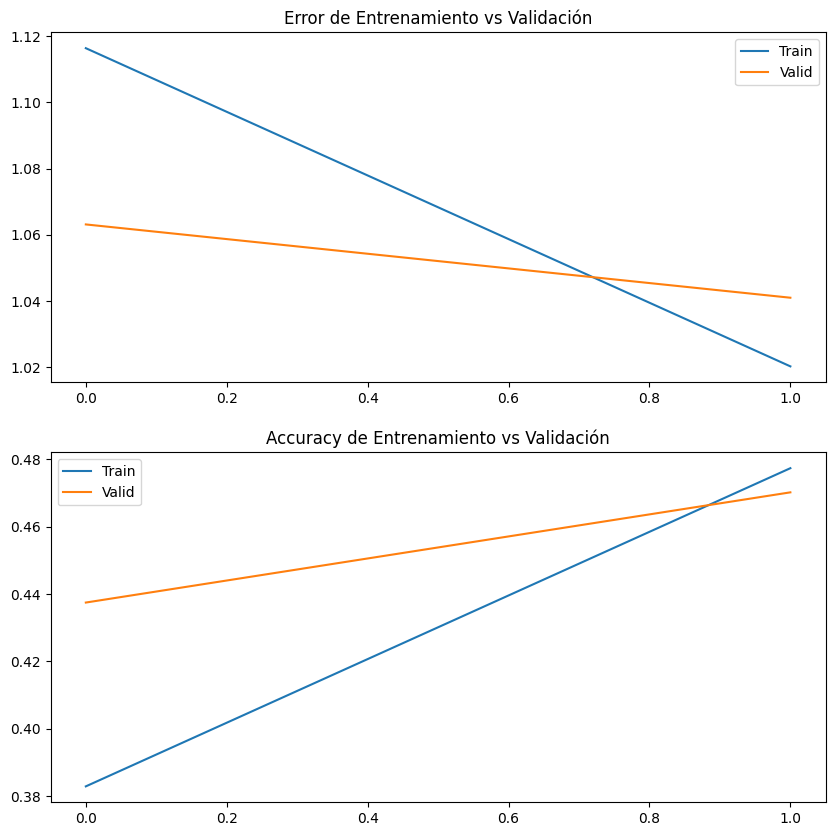

In [ ]:
%%time

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model.parameters()),lr=0.0001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
#writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
#          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}


history = train(resnet18_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                2)
                #writer

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])


"""
Epoch: 1/15 - Train loss 0.985177 - Train Accuracy 0.374684 - Valid Loss 0.968115 - Valid Accuracy 0.385228
Epoch: 2/15 - Train loss 0.895310 - Train Accuracy 0.419243 - Valid Loss 0.934302 - Valid Accuracy 0.418434
Epoch: 3/15 - Train loss 0.866865 - Train Accuracy 0.437861 - Valid Loss 0.923185 - Valid Accuracy 0.431637
Epoch: 4/15 - Train loss 0.847533 - Train Accuracy 0.449203 - Valid Loss 0.918754 - Valid Accuracy 0.446518
Epoch: 5/15 - Train loss 0.835963 - Train Accuracy 0.457448 - Valid Loss 0.897940 - Valid Accuracy 0.445474
Epoch: 6/15 - Train loss 0.820139 - Train Accuracy 0.467866 - Valid Loss 0.892738 - Valid Accuracy 0.451844
Epoch: 7/15 - Train loss 0.813855 - Train Accuracy 0.469385 - Valid Loss 0.900516 - Valid Accuracy 0.451099
Epoch: 8/15 - Train loss 0.805010 - Train Accuracy 0.481770 - Valid Loss 0.887045 - Valid Accuracy 0.451594
Epoch: 9/15 - Train loss 0.802300 - Train Accuracy 0.482244 - Valid Loss 0.878832 - Valid Accuracy 0.461448
Epoch: 10/15 - Train loss 0.799264 - Train Accuracy 0.482638 - Valid Loss 0.863411 - Valid Accuracy 0.465978
Epoch: 11/15 - Train loss 0.794452 - Train Accuracy 0.488224 - Valid Loss 0.891754 - Valid Accuracy 0.467633
Epoch: 12/15 - Train loss 0.795217 - Train Accuracy 0.492341 - Valid Loss 0.862713 - Valid Accuracy 0.468554
Epoch: 13/15 - Train loss 0.788978 - Train Accuracy 0.491631 - Valid Loss 0.852879 - Valid Accuracy 0.466796
Epoch: 14/15 - Train loss 0.787331 - Train Accuracy 0.496854 - Valid Loss 0.858340 - Valid Accuracy 0.469349
Epoch: 15/15 - Train loss 0.783415 - Train Accuracy 0.501027 - Valid Loss 0.851920 - Valid Accuracy 0.472704

"""

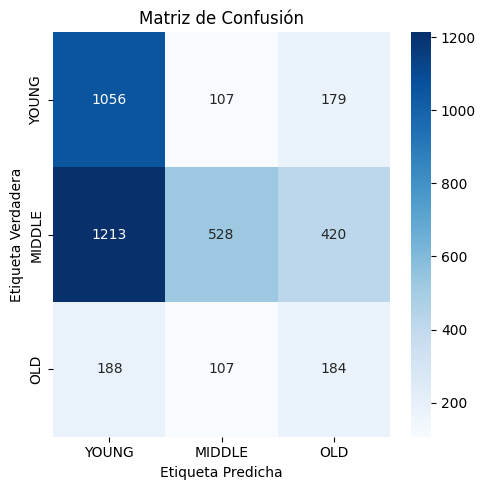

In [ ]:
#Realizamos las predicciones con el modelo
y_true, y_pred = calcular_matriz_confusion(resnet18_model, aug_valid_loader)

#Calculamos la matriz de confusion
matriz_confusion = confusion_matrix(y_true, y_pred)

clases = ['YOUNG', 'MIDDLE', 'OLD']

#Ploteamos la matriz de confusion
graficar_matriz_confusion(matriz_confusion, clases)

In [ ]:
model_name = "resnet18_fc"
models_history[model_name] = history

# 5. TRANSFER LEARNING RESNET18 LAST LAYER WITH DROPOUT

In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
resnet18_model = resnet18(weights=weights)

resnet18_model.to("cuda")

print(resnet18_model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Congelar todas las capas inicialmente
for param in resnet18_model.parameters():
    param.requires_grad = False

# Descongelar las capas del último bloque (layer4)
for layer in resnet18_model.layer4:
    for param in layer.parameters():
        param.requires_grad = True  # Habilitar el entrenamiento para las capas de layer4

# Descongelar la capa final (fc)
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

# Definir un bloque básico modificado que incluye Dropout
class BasicBlockWithDropout(torch.nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.5):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # Guardar la capa de downsample si se necesita

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Aplicar Dropout después de la ReLU

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Reemplazar layer4 en el modelo con bloques que contienen Dropout
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18, self).__init__()
        self.resnet = original_model

        # Reemplazar layer4 con bloques que contienen Dropout
        self.resnet.layer4 = self._replace_with_dropout(self.resnet.layer4)

    def _replace_with_dropout(self, layer4):
        new_layer4 = []
        for block in layer4:
            in_channels = block.conv1.in_channels
            out_channels = block.conv2.out_channels
            stride = block.stride
            downsample = block.downsample

            # Crear el nuevo bloque con Dropout
            new_block = BasicBlockWithDropout(in_channels, out_channels, stride=stride, downsample=downsample, dropout_prob=0.5)
            new_layer4.append(new_block)

        return torch.nn.Sequential(*new_layer4)

    def forward(self, x):
        return self.resnet(x)

# Creamos el modelo modificado
resnet18_model_mod = ModifiedResNet18(resnet18_model)


check_requires_grad(resnet18_model_mod)

resnet.conv1.weight: requires_grad = False
resnet.bn1.weight: requires_grad = False
resnet.bn1.bias: requires_grad = False
resnet.layer1.0.conv1.weight: requires_grad = False
resnet.layer1.0.bn1.weight: requires_grad = False
resnet.layer1.0.bn1.bias: requires_grad = False
resnet.layer1.0.conv2.weight: requires_grad = False
resnet.layer1.0.bn2.weight: requires_grad = False
resnet.layer1.0.bn2.bias: requires_grad = False
resnet.layer1.1.conv1.weight: requires_grad = False
resnet.layer1.1.bn1.weight: requires_grad = False
resnet.layer1.1.bn1.bias: requires_grad = False
resnet.layer1.1.conv2.weight: requires_grad = False
resnet.layer1.1.bn2.weight: requires_grad = False
resnet.layer1.1.bn2.bias: requires_grad = False
resnet.layer2.0.conv1.weight: requires_grad = False
resnet.layer2.0.bn1.weight: requires_grad = False
resnet.layer2.0.bn1.bias: requires_grad = False
resnet.layer2.0.conv2.weight: requires_grad = False
resnet.layer2.0.bn2.weight: requires_grad = False
resnet.layer2.0.bn2.bias:

In [ ]:
print(resnet18_model_mod)

ModifiedResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Epoch: 1/2 - Train loss 0.843191 - Train Accuracy 0.617678 - Valid Loss 0.903800 - Valid Accuracy 0.602201
Epoch: 2/2 - Train loss 0.742160 - Train Accuracy 0.686494 - Valid Loss 0.734538 - Valid Accuracy 0.673441
CPU times: user 3min 13s, sys: 1.86 s, total: 3min 15s
Wall time: 3min 22s


'\n\nEpoch: 1/15 - Train loss 0.838768 - Train Accuracy 0.615530 - Valid Loss 0.734852 - Valid Accuracy 0.665072\nEpoch: 2/15 - Train loss 0.732556 - Train Accuracy 0.683855 - Valid Loss 0.690467 - Valid Accuracy 0.689082\nEpoch: 3/15 - Train loss 0.693090 - Train Accuracy 0.699967 - Valid Loss 0.708747 - Valid Accuracy 0.700369\nEpoch: 4/15 - Train loss 0.653348 - Train Accuracy 0.727869 - Valid Loss 0.654698 - Valid Accuracy 0.717436\nEpoch: 5/15 - Train loss 0.632733 - Train Accuracy 0.740956 - Valid Loss 0.598895 - Valid Accuracy 0.754511\nEpoch: 6/15 - Train loss 0.613339 - Train Accuracy 0.749327 - Valid Loss 0.575894 - Valid Accuracy 0.770304\nEpoch: 7/15 - Train loss 0.582883 - Train Accuracy 0.760852 - Valid Loss 0.662084 - Valid Accuracy 0.733095\nEpoch: 8/15 - Train loss 0.565668 - Train Accuracy 0.767694 - Valid Loss 0.560678 - Valid Accuracy 0.766863\nEpoch: 9/15 - Train loss 0.550285 - Train Accuracy 0.775558 - Valid Loss 0.540764 - Valid Accuracy 0.773425\nEpoch: 10/15 -

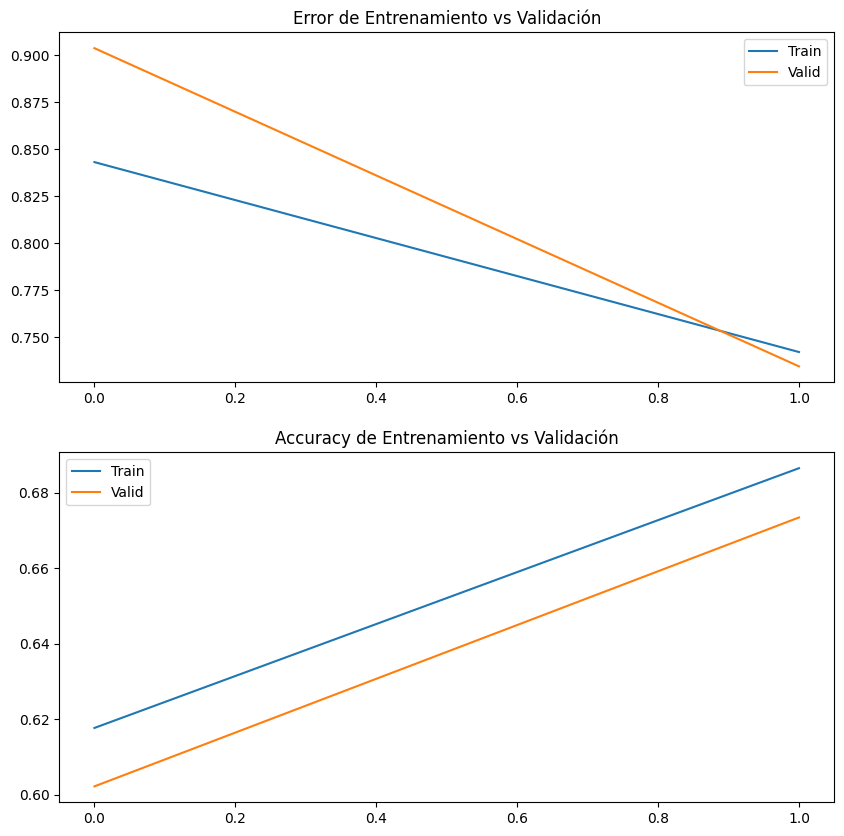

In [ ]:
%%time
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model_mod.parameters()),lr=0.0001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
#writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
#          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}


history = train(resnet18_model_mod.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                2)
                #writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

"""

Epoch: 1/15 - Train loss 0.838768 - Train Accuracy 0.615530 - Valid Loss 0.734852 - Valid Accuracy 0.665072
Epoch: 2/15 - Train loss 0.732556 - Train Accuracy 0.683855 - Valid Loss 0.690467 - Valid Accuracy 0.689082
Epoch: 3/15 - Train loss 0.693090 - Train Accuracy 0.699967 - Valid Loss 0.708747 - Valid Accuracy 0.700369
Epoch: 4/15 - Train loss 0.653348 - Train Accuracy 0.727869 - Valid Loss 0.654698 - Valid Accuracy 0.717436
Epoch: 5/15 - Train loss 0.632733 - Train Accuracy 0.740956 - Valid Loss 0.598895 - Valid Accuracy 0.754511
Epoch: 6/15 - Train loss 0.613339 - Train Accuracy 0.749327 - Valid Loss 0.575894 - Valid Accuracy 0.770304
Epoch: 7/15 - Train loss 0.582883 - Train Accuracy 0.760852 - Valid Loss 0.662084 - Valid Accuracy 0.733095
Epoch: 8/15 - Train loss 0.565668 - Train Accuracy 0.767694 - Valid Loss 0.560678 - Valid Accuracy 0.766863
Epoch: 9/15 - Train loss 0.550285 - Train Accuracy 0.775558 - Valid Loss 0.540764 - Valid Accuracy 0.773425
Epoch: 10/15 - Train loss 0.536440 - Train Accuracy 0.784918 - Valid Loss 0.538807 - Valid Accuracy 0.786882
Epoch: 11/15 - Train loss 0.523080 - Train Accuracy 0.790057 - Valid Loss 0.536180 - Valid Accuracy 0.779460
Epoch: 12/15 - Train loss 0.510498 - Train Accuracy 0.793248 - Valid Loss 0.519509 - Valid Accuracy 0.790716
Epoch: 13/15 - Train loss 0.494227 - Train Accuracy 0.804141 - Valid Loss 0.512061 - Valid Accuracy 0.795652
Epoch: 14/15 - Train loss 0.480661 - Train Accuracy 0.804920 - Valid Loss 0.495278 - Valid Accuracy 0.801839
Epoch: 15/15 - Train loss 0.473790 - Train Accuracy 0.809377 - Valid Loss 0.557283 - Valid Accuracy 0.781787

"""

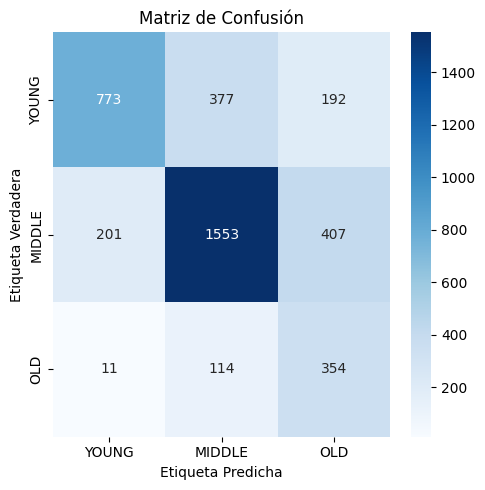

In [ ]:
#Realizamos las predicciones con el modelo
y_true, y_pred = calcular_matriz_confusion(resnet18_model_mod, aug_valid_loader)

#Calculamos la matriz de confusion
matriz_confusion = confusion_matrix(y_true, y_pred)

clases = ['YOUNG', 'MIDDLE', 'OLD']

#Ploteamos la matriz de confusion
graficar_matriz_confusion(matriz_confusion, clases)

In [ ]:
model_name = "resnet18_lastlayer_dropout"
models_history[model_name] = history

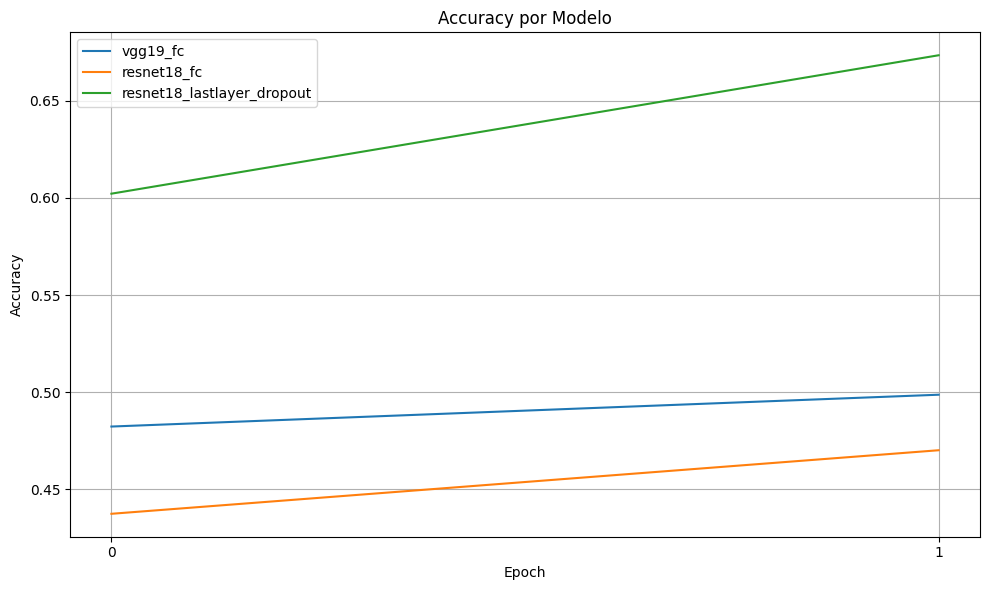

In [ ]:
#Graficamos los resultados de los modelos
plt.figure(figsize=(10, 6))

for model_name, history in models_history.items():
    plt.plot(history['valid_acc'], label=model_name)


plt.title('Accuracy por Modelo')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(range(len(next(iter(models_history.values()))['valid_acc'])))
plt.tight_layout()


plt.show()

# 6. TRANSFER LEARNING VGG19 LAST LAYER

In [ ]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
vgg19_model = torchvision.models.vgg19(weights=weights)
vgg19_model.to("cuda")
print(vgg19_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 81.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# Congelamos toda la red
for param in vgg19_model.parameters():
    param.requires_grad = False

# Activamos la última capa convolucional
for param in vgg19_model.features[34].parameters():
    param.requires_grad = True


# Cambiamos la fully connected y desbloqueamos sus parámetros
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

# Activamos todas las capas de classifier
for param in vgg19_model.classifier.parameters():
    param.requires_grad = True

# Verificamos qué capas tienen parámetros entrenables para chequear que quedó correctamente
def check_requires_grad(model):
    for name, param in model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

check_requires_grad(vgg19_model)

features.0.weight: requires_grad=False
features.0.bias: requires_grad=False
features.2.weight: requires_grad=False
features.2.bias: requires_grad=False
features.5.weight: requires_grad=False
features.5.bias: requires_grad=False
features.7.weight: requires_grad=False
features.7.bias: requires_grad=False
features.10.weight: requires_grad=False
features.10.bias: requires_grad=False
features.12.weight: requires_grad=False
features.12.bias: requires_grad=False
features.14.weight: requires_grad=False
features.14.bias: requires_grad=False
features.16.weight: requires_grad=False
features.16.bias: requires_grad=False
features.19.weight: requires_grad=False
features.19.bias: requires_grad=False
features.21.weight: requires_grad=False
features.21.bias: requires_grad=False
features.23.weight: requires_grad=False
features.23.bias: requires_grad=False
features.25.weight: requires_grad=False
features.25.bias: requires_grad=False
features.28.weight: requires_grad=False
features.28.bias: requires_grad=

Epoch: 1/2 - Train loss 0.931458 - Train Accuracy 0.557385 - Valid Loss 0.873572 - Valid Accuracy 0.594704
Epoch: 2/2 - Train loss 0.822206 - Train Accuracy 0.623402 - Valid Loss 0.821075 - Valid Accuracy 0.626586
CPU times: user 4min 49s, sys: 2.94 s, total: 4min 52s
Wall time: 4min 57s


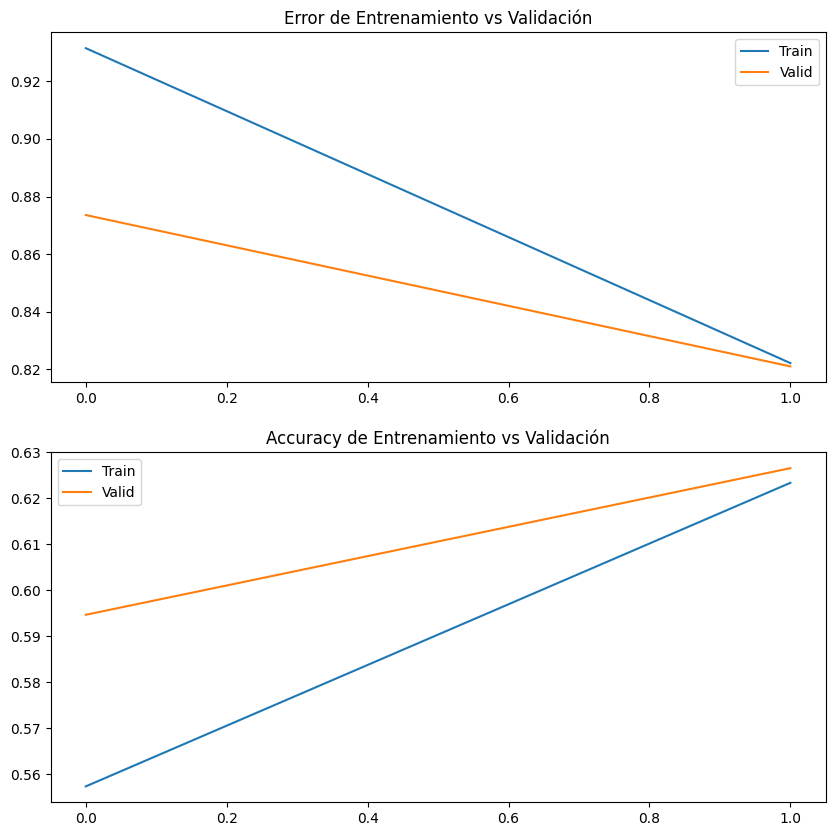

In [ ]:
%%time

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vgg19_model.parameters()),lr=0.0001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
#writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
#          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}


history = train(vgg19_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                2)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])




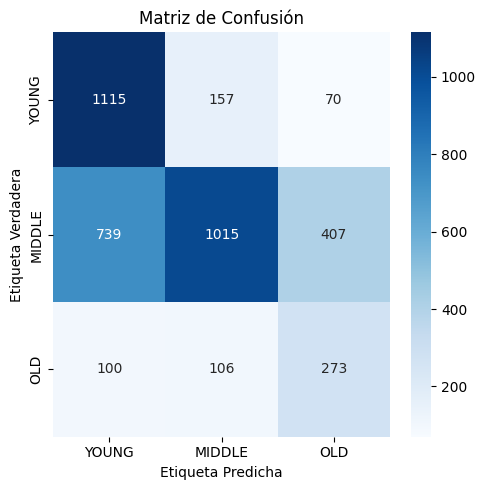

In [ ]:
#Realizamos las predicciones con el modelo
y_true, y_pred = calcular_matriz_confusion(vgg19_model, aug_valid_loader)

#Calculamos la matriz de confusion
matriz_confusion = confusion_matrix(y_true, y_pred)

clases = ['YOUNG', 'MIDDLE', 'OLD']

#Ploteamos la matriz de confusion
graficar_matriz_confusion(matriz_confusion, clases)

In [ ]:
model_name = "vgg19_ultimas_capas"
models_history[model_name] = history

# 7. OPTIMIZACION DE HIPERPARAMETROS